&emsp;&emsp;**Деревья для классификации и регрессии (CART)**

&emsp;&emsp;Идея регрессионного дерева схожа по принципу с алгоритмом к-средних: нужно произвести такую разбивку пространства на кластеры, чтобы дисперсия расстояний точек до центров своих кластеров была меньше, чем дисперсия расстояний до глобального центра. Однако делается это несколько другим способом: 

&emsp;&emsp;1. На первом шаге берем одну переменную из наших данных и разбиваем ее на равные интервалы. Скажем, если переменная принимает значения от 0 до 100, то можно взять в качестве границ интервалов значения 10, 20, 30 и т.д.

&emsp;&emsp;2. Делим данные на 2 группы: одна больше текущего значения переменной (больше 20-ти, к примеру), а другая меньше и вычисляем как сильно снизится дисперсия расстояний внутри полученных групп, по сравнению с общей дисперсией.

&emsp;&emsp;3. Проходимся таким образом по всем переменным и по всем предложенным точкам разбиения. Финально выбираем переменную и точку, разбиение по которой даст максимальное снижение дисперсии.

&emsp;&emsp;4. Получив на предыдущем шаге 2 группы, повторяем этот процесс в каждой из них отдельно до тех пор, пока количество разбиений не достигнет наперед заданного числа.

&emsp;&emsp;Весь процесс напоминает ветвление дерева (отсюда и название), точки разбиения называются узлами, а последние полученные группы данных называются листьями дерева.

&emsp;&emsp;Рассмотрим пример построения дерева для задачи оценки стоимости недвижимости:

In [1]:
import pandas as pd
data = pd.read_csv('RealEstate.csv', sep=',', header=0)

X = data[['X2 house age', 'X3 distance to the nearest MRT station',
          'X4 number of convenience stores', 'X1 transaction date']]

y = data['Y house price of unit area'].values

In [2]:
from sklearn.tree import DecisionTreeRegressor

tre = DecisionTreeRegressor(
    criterion='mse',  # критерий разбивки - уменьшение среднеквадратичной ошибки
    max_depth=2,  # максимальное количество разбивок (глубина дерева)
    min_samples_split=10,  # минимальное кол-во наблюдений, чтобы произвести разбивку
    min_samples_leaf=5  # минимальное кол-во наблюдений, чтобы сформировать лист дерева
).fit(X, y)

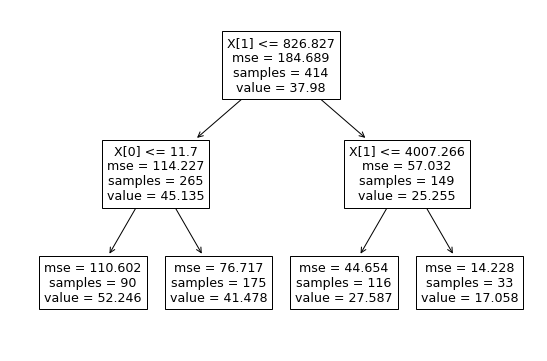

In [3]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

plt.figure(figsize=(9,6))
plot_tree(tre)
plt.show()

&emsp;&emsp;Мы можем воспользоваться той же самой процедурой практически без изменений, нужно только заменить критерий ветвления.

&emsp;&emsp;По аналогии с регрессионным деревом, мы хотим получить наиболее однородные листья. К примеру, если у нас в данных присутствует 3 класса, то нам следует предпочесть лист с распределением [0.95, 0.025, 0.025] листу с распределением [0.3, 0.4, 0.3]. Второй лист можно так же назвать более непредсказуемым, так как классы в нем встречаются практически равновероятно.

&emsp;&emsp;Популярной мерой непредсказуемости является энтропия - величина, которая описывает численно "непредсказуемость" случайной величины:

$$Entropy = -\sum_{i=1}^{n}{p_{i}log(p_{i})}$$

&emsp;&emsp;Где $p_{i}$ - вероятность i-го класса, n - количество классов.

&emsp;&emsp;Рассмотрим пример с подбрасыванием монетки. В тако эксперименте есть всего 2 возможных исхода, вероятность выпадения орла = p, а решки (1-р). Тогда формула энтропии сведется к следующей:

$$CoinEntropy = -plog(p) - (1 - p)log(1-p)$$

&emsp;&emsp;Построим график зависимости энтропии от разныз значений р:

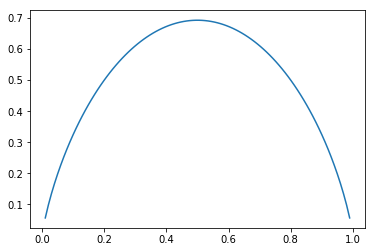

In [4]:
import numpy as np
from matplotlib import pyplot as plt

p = np.linspace(0.01, 0.99, 100)  # создадим набор из разных значений вероятности р
coin_entropy = -p * np.log(p) - (1 - p) * np.log(1 - p)  # вычислим энтропию для каждого из них

plt.plot(p, coin_entropy)
plt.show()

&emsp;&emsp;Как видим, максимального значения энтропия достигает при вероятности р = 0.5, так как в этом случае исход максимально непредсказуемый. В окрестности значений близких к 0 или 1 энтропия близка к 0, так как исход довольно очевиден.

&emsp;&emsp;Другой очень популярной мерой однородности, схожей с энтропией, является индекс Джини, который вычисляется как:

$$Gini = 1 - \sum_{i=1}^{n}{p_{i}^{2}}$$

&emsp;&emsp;Где $p_{i}$ - вероятность i-го класса, n - количество классов.

&emsp;&emsp;Рассмотрим пример классификации на данных о видах ирисов:

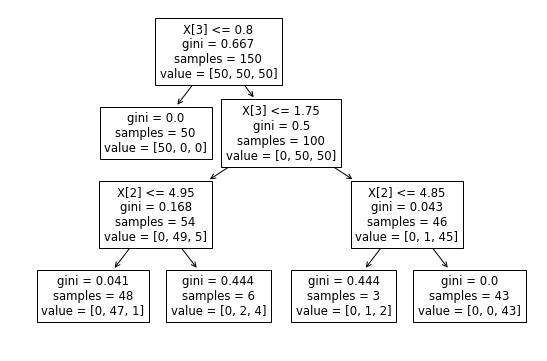

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)
tre = DecisionTreeClassifier(max_depth=3).fit(X, y)

plt.figure(figsize=(9,6))
plot_tree(tre)
plt.show()

&emsp;&emsp;**Bagging**

&emsp;&emsp;Проиллюстрируем идею бэггинга на примере ирисов. Разобьем данные на обучающую и тестовую группу, как всегда, и построим дерево для классификации.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# выгрузим данные
iris = load_iris()
X, y = iris.data[:, :2], iris.target

# сделаем разбивку на обучающую и тестовую группы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# строим модель в виде дерева
mdl = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)

# оценим качество модели
predictions = mdl.predict_proba(X_test)
auc = roc_auc_score(y_test, predictions, average='macro', multi_class='ovr')
print(auc)

0.9114997088681299


&emsp;&emsp;Мы получили AUC на уровне 0.91, воспользовавшись при этом всеми данными обучающего набора. Однако, что было бы, если бы наш обучающий набор был меньше, скажем, 80% от текущего? Построим несколько моделей используя только 80% случайно выбранных данных из обучающего набора и сравним их качество:

In [7]:
num_models = 15  # определим кол-во моделей, которое мы хотим построить
all_predictions = np.zeros((len(y_test), 3), dtype=np.float32)  # массив, в который мы будем добавлять прогнозы
for i in range(num_models):
    
    np.random.seed(i)  # зафиксируем случайное состояние
    
    # получим выборку из обучающего набора размером в 80%
    sub_train_idx = np.random.choice(np.arange(len(X_train)), size=int(0.8 * len(X_train)), replace=False)
    X_sub_train, y_sub_train = X_train[sub_train_idx], y_train[sub_train_idx]
    
    mdl = DecisionTreeClassifier(max_depth=3).fit(X_sub_train, y_sub_train)  # обучим модель
    
    # выведем результат
    print(f'AUC score модели {i}: ', roc_auc_score(y_test, mdl.predict_proba(X_test),
                                                   average='macro', multi_class='ovr'))
    
    all_predictions += mdl.predict_proba(X_test)  # добавим прогноз текущей модели к массиву прогнозов

AUC score модели 0:  0.8169573766064996
AUC score модели 1:  0.8669245715298347
AUC score модели 2:  0.9114997088681299
AUC score модели 3:  0.8954199471743332
AUC score модели 4:  0.877863724968988
AUC score модели 5:  0.8321979190400244
AUC score модели 6:  0.9114153228188316
AUC score модели 7:  0.9062087035771246
AUC score модели 8:  0.8321979190400244
AUC score модели 9:  0.8834535834535835
AUC score модели 10:  0.8293790030632135
AUC score модели 11:  0.9274950845126284
AUC score модели 12:  0.8518894036437897
AUC score модели 13:  0.8494924179134706
AUC score модели 14:  0.8321979190400244


&emsp;&emsp;А теперь посмотрим, какой результат мы получим, если усредним прогнозы всех наших моделей:

In [8]:
avg_predictions = all_predictions / num_models
print(roc_auc_score(y_test, avg_predictions, average='macro', multi_class='ovr'))

0.9389318624844941


&emsp;&emsp;Мы получили результат даже лучше, чем при использовании всех обучающих данных!

&emsp;&emsp;Основная идея бэггинга заключается в том, чтобы построить несколько одинаковых моделей на случайной выборке данных, а затем усреднить их прогнозы. Данные могут при этом повторяться в разных моделях.

&emsp;&emsp;Улучшение происходит за счет того, что модели более или менее независимы друг от друга, так как учились на неодинаковых данных. Кроме того, можно было пойти дальше и обучаться на немного разных наборах переменных, скажем, делать еще и выборку в 80% от всех доступных переменных. Финально, усреднив прогнозы моделей, ошибка одной может быть скомпенсирована более удачной догадкой другой, что приводит к более стабильным и часто более точным результатам.

&emsp;&emsp;Процедура бэггинга общая и может использоваться с любым алгоритмом. Если же она используется в связке с регрессионным или классификационным деревом, как мы сделали выше, то такой подход называют Random Forest. Рассмотрим пример с готовым классом:

In [9]:
from sklearn.ensemble import RandomForestClassifier

mdl = RandomForestClassifier(
    n_estimators=80,  # количество деревьев, которые нужно построить
    criterion='gini',  # критерий построения: повышение однородности в листе дерева
    max_depth=3,  # максимальная глубина дерева
    min_samples_split=10,  # минимальное количество наблюдений, чтобы произвести разбивку данных на 2 подгруппы
    min_samples_leaf=5,  # минимальное количество наблюдений, которое может сформировать лист дерева
    max_features=0.8,  # максимальное кол-во переменных, которыми можно воспользоваться в одном дереве
    bootstrap=True,  # строить ли каждое дерево на выборке из оригинальных данных
    max_samples=0.8,  # для данных, которая может быть использована в построении одного дерева
    random_state=42  # фиксация случайного состояния
)

mdl = mdl.fit(X_train, y_train)  # обучение модели

# оценка качества модели на тестовых данных
auc = roc_auc_score(y_test, mdl.predict_proba(X_test), average='macro', multi_class='ovr')

print(auc)

0.9411407306144147


&emsp;&emsp;**Boosting**

&emsp;&emsp;Идея бустинга схожа с идеей бэггинга в том, что одна модель состоит из множества одинаковых моделей, каждая из которых дает невысокую точность сама по себе, однако коллективно позволяют выйти на довольно высокий результат. Такой подход в общем называется ансамблем. 

&emsp;&emsp;Однако, если в бэггинге все модели строились абсолютно независимо друг от друга (на несколько разных данных, чтобы разные участники ансамбля не были абсолютно одинаковыми), то в бустинге идея другая: каждая следующая модель строится таким образом, чтобы скорректировать ошибку всех предыдущих моделей. Несмотря на то, что бустинг, как и бэггинг, могут быть построены в связке с любым алгоритмом, наибольшую популярность приобрел бустинг в связке с деревьями классификации и регрессии, на примере которых мы и будем разбирать весь процесс.

&emsp;&emsp;Стоит сразу сказать, что существует несколько вариантов бустинга, каждый из которых по-своему трактует понятие ошибки. Самым универсальным и распространенным вариантом (который и будем разбирать) является градиентный бустинг, который позволяет оптимизировать любую дифференциируемую функцию потерь.

&emsp;&emsp;Для задачи регрессии определим прогноз нашей бустинг модели следующим образом:

$$\hat{y_{i}} = \phi(x_{i}) = \sum_{k=1}^{K}{f_{k}(x_{i})}$$

&emsp;&emsp;Здесь $f_{k}(x_{i})$ - некоторая функция, которая применяется к наблюдению $x_{i}$. 
Когда мы делали модель по принципу бэггинга, то такой йункцией было регрессионное дерево или 
какая-то другая модель, обученная на подмножестве данных. Пока все остается точно так же за тем
исключением, что мы не усредняем прогнозы наших моделей, а только суммируем.

&emsp;&emsp;Если $f_{k}$ - регрессинное дерево, то формально мы можем определить $f(x) = 
w_{q(x)}$, где $w$ - некоторое число, которое ассоциируется с листом дерева. Имея конкретное
неблюдение $x$ мы спускаемся по дереву и, в зависимости от условий в каждом узле, выбираем тот
лист $q$, в который попадает наш $x$.

&emsp;&emsp;Пусть для нашей задачи есть некотрая функция потерь $l$, тогда общую ошибку 
прогноза можно записать как

$$L = \sum_{i=1}^{n}{l(y_{i}, y_{i}^{predicted})}$$

&emsp;&emsp;Конкретное значение функции $l$ определяется задачей. Если у нас задача регрессии,
то это может быть квадрат отклонения фактического значения $y_{i}$ от прогнозного
$y_{i}^{predicted}$. Тогда функция потерь перепишется как $L = \sum_{i=1}^{n}{
(y_{i} - \hat{y_{i}})^{2}}$

&emsp;&emsp;Сразу перейдем к более общей форме функции потерь, а именно, если присутствует 
регуляризация модели. Обычно для дерева можно предложить 2 следующие популярные формы 
регуляризации:

&emsp;&emsp;1. $\gamma T$, где $T$ - количество листьев дерева. Это граничение на сложность
дерева: чем меньше глубина дерева и меньше кол-во листьев, тем меньше шанс переобучения. Без
этого ограничения можно построить дерево, в каждом листе которого будет находиться по одному
наблюдению, что даст идеальную точность при обучении, однако будет бесполезно при прогнозе.

&emsp;&emsp;2. $\frac{1}{2} \lambda \sum_{i=1}^{T}{w_{i}^2}$ - стандартная ridge регуляризация, которая
налагается на значения в листах дерева.

&emsp;&emsp;Определим общую регуляризацию для одного дерева как $\Omega(f) = \gamma T + 
\frac{1}{2} \lambda \sum_{i=1}^{T}{w_{i}^2}$. Так как суммарно у нас в модели будет $k$ деревьев, то
общая функция потерь запишется как

$$L = \sum_{i=1}^{n}{l(y_{i}, \hat{y_{i}})} + \sum_{k=1}^{K}{\Omega(f_{k})}$$

&emsp;&emsp;Процесс обучения деревьев происходит следующим образом: сначала строится одно 
дерево, дающее базовый прогноз, затем следующее, результат которого прибавляется к 
результату предыдущего и т.д. Рассмотрим значение функции потерь на том шаге, когда мы
добавляем к модели дерево $t$

$$L^{(t)} = \sum_{i=1}^{n}{l(y_{i}, \hat{y_{i}}^{(t-1)} + f_{t}(x_{i}))} + \Omega (f_{t})$$

&emsp;&emsp;Другими словами, имея $t-1$ деревьев в модели, наша задача добавить дерево $t$ 
таким образом, чтобы максимально снизить общую ошибку.

&emsp;&emsp;Дифференциируемую функцию $f(x)$ в окрестности некоторой точки $a$ можно
приблизительно представить как $f(x) \approx f(a) + f^{'}(a)h + \frac{1}{2} f^{''}(a)h^{2}$, 
где $h=x - a$. 
Воспользуемся этим свойством, чтобы переписать нашу функцию потерь следующим образом:

$$l(y_{i}, \hat{y_{i}}^{(t-1)} + f_{t}(x_{i})) \approx l(y_{i}, \hat{y_{i}}^{t-1}) + g_{i}f_{t}(x_{i}) + \frac{1}{2}h_{i}f_{t}^{2}(x_{i})$$

$$g_{i} = \frac{dl(y_{i}, \hat{y_{i}}^{t-1})}{d\hat{y_{i}}^{t-1}}, h_{i} = \frac{dg_{i}}{d\hat{y_{i}}^{t-1}}$$
&emsp;&emsp;Учитывая, что $l(y_{i}, \hat{y_{i}}^{(t-1)}$ - это константа, которая зависит от
деревьев, построенных на предыдущих шагах, не влияющая на текущее дерево, можем записать 
функцию потерь следующим образом:

$$L^{(t)} = \sum_{i=1}^{n}{[g_{i}f_{t}(x_{i}) + \frac{1}{2}h_{i}f_{t}^{2}(x_{i})]} + \Omega(f_{t})$$

&emsp;&emsp;Определим множество $I_{j} = \{i|q(x_{i})=j\}$ - множество всех индексов наблюдений,
которые после прохода по дереву попадают в лист с индексом j. Вспоминая, что для листа j 
значение функции $f_{t}(x_{i}) = w_{j}$ можем переписать наше уравнение следующим образом:

$$L^{(t)} = \sum_{i=1}^{n}{[g_{i}f_{t}(x_{i}) + \frac{1}{2} h_{i}f_{t}^{2}(x_{i})]} + \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T}{w_{j}^{2}}=$$

$$=\sum_{j=1}^{T}{[(\sum_{i \in I_{j}}{g_{i}})w_{j} + \frac{1}{2}(\sum_{i \in I_{j}}{h_{i}} + \lambda)w_{j}^{2}]} + \gamma T$$

&emsp;&emsp;Взяв производную по $w_{j}$ и приравняв к 0 можем найти оптимальное значение $w_{j}$
для данного дерева:

$$w_{j}^{*} = -\frac{\sum_{i \in I_{j}}{g_{i}}}{\sum_{i \in I_{j}}{h_{i}} + \lambda}$$

&emsp;&emsp;Подставим оптимальное значение $w_{j}$ в функцию потерь и получим соответствующее 
минимальное значение:

$$L^{(t)} = -\frac{1}{2} \sum_{j=1}^{T}{\frac{(\sum_{i \in I_{j}}{g_{i}})^{2}}{\sum_{i \in I_{j}}{h_{i}} + \lambda}} + \gamma T$$

&emsp;&emsp;Последней формулой можно пользоваться для оценки дерева, которое мы добавляем к 
ансамблю. Предпочесть следует то дерево, которое соответствует минимальному значению
предложенной функции. Однако на практике рассмотреть все возможные варианты деревьев
нет возможности из-за слишком большого числа комбинаций возможных разбивок. Поэтому дерево
строится в "жадном" стиле следующим образом:

&emsp;&emsp;1. Выбираем некоторую переменную из набора и делаем разбивку наших данных на 2
группы. В первую группу попадают все наблюдения меньше какого-то значения
(назовем эту группу $I_{L}$), а во вторую все остальные ($I_{R}$). Множество же всех
наблюдений будем называть просто $I$

&emsp;&emsp;2. Сравниваем, насколько снизится значение функции потерь при такой разбивке:

$$L_{split} = [\frac{(\sum_{i \in I_{L}}{g_{i}})^{2}}{\sum_{i \in I_{L}}{h_{i}} + \lambda} + \frac{(\sum_{i \in I_{R}}{g_{i}})^{2}}{\sum_{i \in I_{R}}{h_{i}} + \lambda} - \frac{(\sum_{i \in I}{g_{i}})^{2}}{\sum_{i \in I}{h_{i}} + \lambda}] - \gamma$$

&emsp;&emsp;3. Пройдясь таким образом по всем переменным и по разным значениям, для которых
делается разбивка, выбираем лучшее, после чего повторяем процесс для созданных подгрупп.

&emsp;&emsp;Рассмотрим пример построения модели с данными о кредитном мошенничестве



In [ ]:
import xgboost as xgb

# прочитаем данные из файла
data = pd.read_csv('fraud_detection.csv', sep=';', header=0)

# избавимся от переменной, которой не будем пользоваться
data.drop('Time', inplace=True, axis=1)

# разобьем данные на обучающую и тестовую группу
X, y = data[[col for col in data.columns if col != 'Class']], data['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
# xgboost работает со своим встроенным представлением данных - DMatrix, которая создается как следующим образом:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

# следующий шаг - определить словарь с гиперпараметрами алгоритма
params = {
        'objective': 'binary:logistic',  # целевая функция, которую мы будем минимизировать
        'learning_rate': 0.1,  # параметр скорости обучения
        'subsample': 0.8,  # доля наблюдений, который будет использован в каждом дереве
        'colsample_bytree': 0.8,  # доля переменных, которая будет использована в каждом дереве
        'colsample_bylevel': 0.8,  # доля переменных, которая будет использована при каждой разбивке
        'lambda': 0.5,  # параметр L2 регуляризации
        'gamma': 1.,  # параметр регуляризации, который накладывает ограничение на размер дерева
        'max_depth': 6,  # максимальная глубина каждого дерева
        'min_child_weight': 5,  # параметр, определяющий минимальный размер листа
        'eval_metric': 'auc',  # метрика качества модели
        'silent': 1,  # выводить ли промежуточные вычисления на экран
        'seed': 32  # фиксация случайного состояния
    }

mdl = xgb.train(
    params=params,  # словарь с набором параметров модели
    dtrain=dtrain,  # матрица с обучающими данными
    num_boost_round=50,  # количество деревьев, которые нужно построить
    evals=[(dtrain, 'Train'), (dtest, 'Test')]  # обучающие и тестовые данные для оценки качесва
)


[0]	Train-auc:0.945097	Test-auc:0.928702
[1]	Train-auc:0.947231	Test-auc:0.933015
[2]	Train-auc:0.962265	Test-auc:0.955333
[3]	Train-auc:0.962418	Test-auc:0.955369
[4]	Train-auc:0.968617	Test-auc:0.954918
[5]	Train-auc:0.968945	Test-auc:0.95467
[6]	Train-auc:0.972793	Test-auc:0.960281
[7]	Train-auc:0.975575	Test-auc:0.968156
[8]	Train-auc:0.978948	Test-auc:0.977042
[9]	Train-auc:0.978722	Test-auc:0.977181
[10]	Train-auc:0.978663	Test-auc:0.977044
[11]	Train-auc:0.983436	Test-auc:0.976349
[12]	Train-auc:0.983352	Test-auc:0.976398
[13]	Train-auc:0.983272	Test-auc:0.981531
[14]	Train-auc:0.984165	Test-auc:0.98053
[15]	Train-auc:0.985698	Test-auc:0.980503
[16]	Train-auc:0.985642	Test-auc:0.980836
[17]	Train-auc:0.98831	Test-auc:0.97957
[18]	Train-auc:0.988143	Test-auc:0.979187
[19]	Train-auc:0.988531	Test-auc:0.978799
[20]	Train-auc:0.9891	Test-auc:0.97846
[21]	Train-auc:0.989215	Test-auc:0.98026
[22]	Train-auc:0.990543	Test-auc:0.979933
[23]	Train-auc:0.990469	Test-auc:0.979872
[24]	Train

&emsp;&emsp;Возможно, самым важным параметром всей модели является количество деревьев. Если взять
слишком мало, то модель останется недоученной, а если много, то высок риск переобучения. На 
практике применяют технику ранней остановки: мы продолжаем добавлять новые деревья к ансамблю до
тех пор, пока ошибка на тестовом наборе не начнет увеличиваться (признак того, что мы достигли
момента переобучения). Однако иногда случаются скачки в метрике качества: точность может немного
ухудшиться, а на следующем дереве опять улучшиться. Поэтому правило немного ослабляют до следующей 
формы: продолжаем добавлять новые деревья до тех пор, пока ошибка на тестовом наборе не ухудшается
в течение n итераций подряд (на практике берут 10-20 итераций)



In [12]:
mdl = xgb.train(
    params=params,
    dtrain=dtrain, 
    num_boost_round=500,  # возьмем заведомо преувеличенное кол-во деревьев
    early_stopping_rounds=20,  # кол-во шагов с ухудшением метрики на тесте, после которого прекращаем обучение
    evals=[(dtrain, 'Train'), (dtest, 'Test')]
)

[0]	Train-auc:0.945097	Test-auc:0.928702
Multiple eval metrics have been passed: 'Test-auc' will be used for early stopping.

Will train until Test-auc hasn't improved in 20 rounds.
[1]	Train-auc:0.947231	Test-auc:0.933015
[2]	Train-auc:0.962265	Test-auc:0.955333
[3]	Train-auc:0.962418	Test-auc:0.955369
[4]	Train-auc:0.968617	Test-auc:0.954918
[5]	Train-auc:0.968945	Test-auc:0.95467
[6]	Train-auc:0.972793	Test-auc:0.960281
[7]	Train-auc:0.975575	Test-auc:0.968156
[8]	Train-auc:0.978948	Test-auc:0.977042
[9]	Train-auc:0.978722	Test-auc:0.977181
[10]	Train-auc:0.978663	Test-auc:0.977044
[11]	Train-auc:0.983436	Test-auc:0.976349
[12]	Train-auc:0.983352	Test-auc:0.976398
[13]	Train-auc:0.983272	Test-auc:0.981531
[14]	Train-auc:0.984165	Test-auc:0.98053
[15]	Train-auc:0.985698	Test-auc:0.980503
[16]	Train-auc:0.985642	Test-auc:0.980836
[17]	Train-auc:0.98831	Test-auc:0.97957
[18]	Train-auc:0.988143	Test-auc:0.979187
[19]	Train-auc:0.988531	Test-auc:0.978799
[20]	Train-auc:0.9891	Test-auc:0.

&emsp;&emsp;Чтобы не полагаться на один тестовый набор, можно воспользоваться кросс-валидацией:

In [27]:
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    early_stopping_rounds=20,
    nfold=4,  # кол-во разбивок для кросс-валидации
    verbose_eval=True  # выводить ли на экран промежуточные результаты
)

[0]	train-auc:0.933645+0.00937253	test-auc:0.924769+0.015798
[1]	train-auc:0.94529+0.00562609	test-auc:0.930719+0.0145683
[2]	train-auc:0.962082+0.00681989	test-auc:0.944448+0.0127975
[3]	train-auc:0.966046+0.00483466	test-auc:0.949649+0.00835205
[4]	train-auc:0.970245+0.00192857	test-auc:0.951836+0.00898381
[5]	train-auc:0.972235+0.00310466	test-auc:0.952653+0.00841001
[6]	train-auc:0.972328+0.00339132	test-auc:0.954929+0.0065222
[7]	train-auc:0.973594+0.00237363	test-auc:0.955754+0.00738091
[8]	train-auc:0.975343+0.00301282	test-auc:0.956288+0.00720351
[9]	train-auc:0.976325+0.00254952	test-auc:0.959817+0.00563475
[10]	train-auc:0.977596+0.00333668	test-auc:0.960874+0.00540132
[11]	train-auc:0.978517+0.00460874	test-auc:0.960968+0.00515205
[12]	train-auc:0.98043+0.00338739	test-auc:0.960715+0.00528931
[13]	train-auc:0.980389+0.00351842	test-auc:0.96097+0.00523931
[14]	train-auc:0.983815+0.00542399	test-auc:0.961788+0.00564831
[15]	train-auc:0.984922+0.00601235	test-auc:0.960662+0.005

&emsp;&emsp;Выбор оптимального набора гиперпараметров принято проводить на кросс-валидации 

In [30]:
from sklearn.model_selection import GridSearchCV

# зададим начальный набор параметров включая кол-во деревьев
params = {'objective': 'binary:logistic', 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8,
          'colsample_bylevel': 0.8, 'reg_lambda': 0.5, 'gamma': 1., 'max_depth': 6, 'min_child_weight': 5,
          'eval_metric': 'auc', 'silent': 1, 'seed': 32, 'n_estimators': 30}

# чтобы иметь возможность использовать GridSearchCV из sklearn модель нужно определить как XGBClassifier
xgb_mdl = xgb.XGBClassifier(**params)

# зададим сетку возможных значений параметров для перебора
params_grid = {'max_depth': [4, 6, 8], 'min_child_weight': [3, 6, 9]}

# обучение модели на всех группах кросс-валидации
clf = GridSearchCV(
    estimator=xgb_mdl,  # модель классификации, параметры которой ищутся
    param_grid=params_grid,  # сетка с набором параметров
    scoring='roc_auc',  # метрика качества, которую нужно оптимизировать
    cv=4  # кол-во разбивок на кросс-валидации
).fit(X, y)

results = pd.DataFrame(clf.cv_results_)
best_result = results[results['rank_test_score'] == 1]
print(best_result['params'].values, best_result['mean_test_score'].values)

[{'max_depth': 4, 'min_child_weight': 6}] [0.97243821]
